# 02 - GEDI L2A: test case - Mangroves

<div class="alert alert-warning">

**GEDI-2A DATA DICTIONARY**:

Een referentielijst met alle terminologie van de GEDI-Level 2A shots is te vinden op: [https://lpdaac.usgs.gov/documents/586/gedi_l2a_dictionary_P001_v1.html](https://lpdaac.usgs.gov/documents/586/gedi_l2a_dictionary_P001_v1.html) 

In onderstaande voorbeelden gaan we dieper in op de visualisatie van een GEDI-Level-2A shots voor het mangrovebos in Saramacca.

### 1. Inladen packages

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
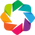

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import geopandas as gp
from shapely.geometry import Point
import geoviews as gv
from geoviews import opts, tile_sources as gvts
import holoviews as hv
gv.extension('bokeh', 'matplotlib')

In [2]:
# Volgende code maakt een link aan van je datafolder, waar je gedownloade GEDI-datafile zou moeten staan
dataDir = os.getcwd() + os.sep + 'data' + os.sep

In [3]:
dataDir

'C:\\Users\\jaspe\\Documents\\GCCA\\Trainingen\\GCCA_GEDI\\data\\'

In [4]:
gediFiles = [g for g in os.listdir(dataDir) if g.startswith('GEDI02_A') and g.endswith('.h5')]  # List all GEDI L1B .h5 files in inDir
gediFiles

['GEDI02_A_2021253225016_O15557_02_T08230_02_003_02_V002.h5']

Hier zie en onmiddellijk het formaat van een GEDI-dataset: 

> **GEDI02_A**: Naam van GEDI product
**2019170155833**: Datum en tijd van opname volgens Juliaanse notatie (YYYYDDDHHMMSS)  
**O02932**: Orbit Number
**02**: Sub-Orbit Granule Number (1-4)  
**T02267**: Track Number (Reference Ground Track)  
**02**: Positioning and Pointing Determination System (PPDS) type (00 is predict, 01 rapid, 02 and higher is final)  
**003**: PGE Version Number  
**01**: Granule Production Version  
**V002**: Product Version

In [15]:
L2A = gediFiles[0]
L2A

'GEDI02_A_2021253225016_O15557_02_T08230_02_003_02_V002.h5'

### Inlezen van een HDF5-file

In [7]:
gediL2A = h5py.File('data'+"\\" + L2A,'r')

In [16]:
gediL2A

<HDF5 file "GEDI02_A_2021253225016_O15557_02_T08230_02_003_02_V002.h5" (mode r)>

### Bekijken van aanwezige *keys*

In [17]:
beamNames = list(gediL2A.keys())
beamNames

['BEAM0000',
 'BEAM0001',
 'BEAM0010',
 'BEAM0011',
 'BEAM0101',
 'BEAM0110',
 'BEAM1000',
 'BEAM1011',
 'METADATA']

Uit de lijst hierboven zie je dat de dataset is onderverdeeld in 8 verschillende 'BEAMS' + een METADATA-file.  

Dit is omwille van het feit data GEDI in totaal 8 'shots' maakt per moment, over afstand van 4.2 km.

Hiervan zijn de helft van de BEAM's *full power* beams, en de helft *coverage* beams. Het verschil is dat de 'coverage' beams slechts tot 95% in het kronendak penetreren, terwijl de full beams sterkere shots zijn. Zeker voor dense bossen zijn deze type beams niet bruikbaar. Doorgaans wordt aangeraden enkel met de *full power* beams te werken.

![img/GEDI_BEAMS.jpg](img\GEDI_BEAMS.jpg)

Verder kunnen we bekijken welke informatie opgeslagen zit in de metadata:

In [18]:
for g in gediL2A['METADATA']['DatasetIdentification'].attrs: print(g) 

PGEVersion
VersionID
abstract
characterSet
creationDate
credit
fileName
language
originatorOrganizationName
purpose
shortName
spatialRepresentationType
status
topicCategory
uuid


In [22]:
print(gediL2A['METADATA']['DatasetIdentification'].attrs['purpose'])


The purpose of the L2A dataset is to provide waveform interpretation and extracted products from each GEDI waveform.  This includes ground elevation, canopy top height, relative return energy metrics (describing canopy vertical structure, for example), and many other interpreted products from the return waveforms.


We kunnen de beamnames ook bekijken:

In [23]:
#Zorgen dat enkel de elementen met 'BEAM' overblijven in de lijst
beamNames = [g for g in gediL2A.keys() if g.startswith('BEAM')]
beamNames

['BEAM0000',
 'BEAM0001',
 'BEAM0010',
 'BEAM0011',
 'BEAM0101',
 'BEAM0110',
 'BEAM1000',
 'BEAM1011']

In [25]:
for b in beamNames: 
    print(f"{b} is a {gediL2A[b].attrs['description']}")
    print(f"{b} has as number {np.unique(gediL2A[b+ '/beam'][()])[0]}")

BEAM0000 is a Coverage beam
BEAM0000 has as number 0
BEAM0001 is a Coverage beam
BEAM0001 has as number 1
BEAM0010 is a Coverage beam
BEAM0010 has as number 2
BEAM0011 is a Coverage beam
BEAM0011 has as number 3
BEAM0101 is a Full power beam
BEAM0101 has as number 5
BEAM0110 is a Full power beam
BEAM0110 has as number 6
BEAM1000 is a Full power beam
BEAM1000 has as number 8
BEAM1011 is a Full power beam
BEAM1011 has as number 11


Vervolgens pikken we hier eentje uit, om verder na te gaan wat in elke BEAM zit opgeslagen

In [26]:
beamNames

['BEAM0000',
 'BEAM0001',
 'BEAM0010',
 'BEAM0011',
 'BEAM0101',
 'BEAM0110',
 'BEAM1000',
 'BEAM1011']

In [27]:
gediL2A_objs = []
gediL2A.visit(gediL2A_objs.append)                                           # Retrieve list of datasets
gediSDS = [o for o in gediL2A_objs if isinstance(gediL2A[o], h5py.Dataset)]  # Search for relevant SDS inside data file
[i for i in gediSDS if 'BEAM1000' in i][0:10]

['BEAM1000/ancillary/l2a_alg_count',
 'BEAM1000/beam',
 'BEAM1000/channel',
 'BEAM1000/degrade_flag',
 'BEAM1000/delta_time',
 'BEAM1000/digital_elevation_model',
 'BEAM1000/digital_elevation_model_srtm',
 'BEAM1000/elev_highestreturn',
 'BEAM1000/elev_lowestmode',
 'BEAM1000/elevation_bias_flag']

## 4. Visualizeren van een GEDI Orbit

In onderstaande code halen we de geografische  informatie uit de GEDI SDS (=Science DataSet), wat per beam opgeslagen zit. 

In [28]:
lonSample, latSample, shotSample, qualitySample, beamSample = [], [], [], [], []  # Set up lists to store data

# Open the SDS
lats = gediL2A['BEAM1000/lat_lowestmode'][()]
lons = gediL2A['BEAM1000/lon_lowestmode'][()]
shots = gediL2A['BEAM1000/shot_number'][()]
quality = gediL2A['BEAM1000/quality_flag'][()]

# Take every 10th shot and append to list
for i in range(len(shots)):
    if i % 10 == 0:
        shotSample.append(str(shots[i]))
        lonSample.append(lons[i])
        latSample.append(lats[i])
        qualitySample.append(quality[i])
        beamSample.append('Beam1000')

# Write all of the sample shots to a dataframeb
latslons = pd.DataFrame({'Beam': beamSample, 'Shot Number': shotSample, 'Longitude': lonSample, 'Latitude': latSample,
                         'Quality Flag': qualitySample})
latslons

,Beam,Shot Number,Longitude,Latitude,Quality Flag
0,Beam1000,155570800200076485,-60.105509,-0.238532,0
1,Beam1000,155570800200076495,-60.102534,-0.234325,0
2,Beam1000,155570800200076505,-60.099557,-0.230120,0
3,Beam1000,155570800200076515,-60.096583,-0.225915,0
4,Beam1000,155570800200076525,-60.093611,-0.221707,0
...,...,...,...,...,...
12681,Beam1000,155570800200204610,23.508713,51.783247,1
12682,Beam1000,155570800200204620,23.516979,51.783296,1
12683,Beam1000,155570800200204630,23.525243,51.783345,1
12684,Beam1000,155570800200204640,23.533509,51.783396,1


In [29]:
#Sommige variabelen hebben we niet meer nodig, dus verwijderen we die:
del beamSample, quality, qualitySample, gediL2A_objs, latSample, lats, lonSample, lons, shotSample, shots 

Met Geopandas kunnen we een GeoDataFrame aanmaken, op basis van de Longitude en Latitude kolommen:

In [30]:
latslons['geometry'] = latslons.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)

In [31]:
type(latslons)

pandas.core.frame.DataFrame

In [32]:
#O Omzetten naar een GeoDataFrame
latslons = gp.GeoDataFrame(latslons)
latslons = latslons.drop(columns=['Latitude','Longitude'])
latslons['geometry']

0        POINT (-60.10551 -0.23853)
1        POINT (-60.10253 -0.23432)
2        POINT (-60.09956 -0.23012)
3        POINT (-60.09658 -0.22591)
4        POINT (-60.09361 -0.22171)
                    ...            
12681     POINT (23.50871 51.78325)
12682     POINT (23.51698 51.78330)
12683     POINT (23.52524 51.78335)
12684     POINT (23.53351 51.78340)
12685     POINT (23.54343 51.78345)
Name: geometry, Length: 12686, dtype: geometry

In [33]:
latslons.crs

Er is nog geen CRS toegekend, maar we weten dat deze EPSG=4326 heeft, onderstaande code past dit aan:

In [34]:
latslons = latslons.set_crs(epsg=4326)

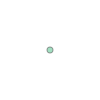

In [35]:
#Hier kunnen we weer een punt bekijken
latslons['geometry'][0]


In [36]:
###Visualizeren van de Volledige GeoDataFrame:
ax = latslons.explore()

Bovenstaande zegt ons nog niet zoveel, daarom gaan we via een extra plotmethode ook een achtergrond toevoegen:

In [37]:
# Define a function for visualizing GEDI points
def pointVisual(features, vdims):
    return (gvts.EsriImagery * gv.Points(features, vdims=vdims).options(tools=['hover'], height=500, width=900, size=5, 
                                                                        color='yellow', fontsize={'xticks': 10, 'yticks': 10, 
                                                                                                  'xlabel':16, 'ylabel': 16})) 


# Inlezen van Mangrove-ROI

In [38]:
Mangrove_ROI = gp.read_file('data/ROI_Mangroves.zip')

In [39]:
Mangrove_ROI = Mangrove_ROI.to_crs(latslons.crs)

In [40]:
# Create a list of geodataframe columns to be included as attributes in the output map
vdims = []
for f in latslons:
    if f not in ['geometry']:
        vdims.append(f)
vdims

['Beam', 'Shot Number', 'Quality Flag']

In [43]:
gv.Polygons(Mangrove_ROI['geometry']).opts(line_color='red', color=None) * pointVisual(latslons, vdims = vdims)

:Overlay
   .Polygons.I :Polygons   [Longitude,Latitude]
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Points.I   :Points   [Longitude,Latitude]   (Beam,Shot Number,Quality Flag)

Bij het bekijken van de data, zie je 'Quality Flag' met een 0 of een 1. We kunnen nagaan wat dit precies betekent:

In [42]:
print(f"Quality Flag: {gediL2A[b]['quality_flag'].attrs['description']}")


Quality Flag: Flag simpilfying selection of most useful data


# GEDI-L2A data: RH-metrics

GEDI-L2A levert de Relative Height-metrieken, wat een typische LiDAR-metrieken zijn. Deze gaan van RH_0 tot RH_100, waarbij:

* **RH 100** = elev_highestreturn - elev_lowestmode.
              Dit is het verschil tussen de grootste hoogte waarop een 'return'-waarde werd geregistreerd en de vooropgestelde hoogte van het laagste punt (= de grond). Deze hoogte-waarden worden relatief gemeten, maar om dit naar absolute getallen om te zetten maakt GEDI gebruik van het WGS-hoogtemodel. 

* **RH_0** = Hoogte van de laagste return = bodem

* De lagere RH-waarden kunnen **negatieve** waarden hebben, omdat vaak een groter % van de teruggekeerde energie van de grond komt

## Specifieke shots inladen

Eerst kijken we hoeveel unieke shots aanwezig zijn in onze file:

In [44]:
# Hoeveel unieke shots zitten in onze file?
len(gediSDS)

4320

In [45]:
beamSDS = [g for g in gediSDS if 'BEAM1000' in g]  # Subset to a single beam
len(beamSDS)

540

Hieruit gaan we één shot halen, ter illustratie van hoe dergelijke return er uit ziet. Dit doen we op basis van het unieke *shotnummer*. 

Hier kiezen we voor een shot die binnen de mangrove-zone valt. (vooraf geselecteerd via bovenstaande figuren).

In [46]:
shot = 155570800200091194

In [47]:
index = np.where(gediL2A['BEAM1000/shot_number'][()]==shot)[0][0]  # Set the index for the shot identified above
index

14709

In [48]:
rh = gediL2A[[g for g in beamSDS if g.endswith('/rh')][0]]  # Relative Height Metrics

Print de omschrijving van de rh dataset, om hier inzicht in te krijgen:

In [49]:
print(f"rh is {rh.attrs['description']}")

rh is Relative height metrics at 1 % interval


In [50]:
algo = gediL2A[f'{beamNames[0]}/selected_algorithm']  # selected algorithm
print(f"selected_algorithm is {algo.attrs['description']}")

selected_algorithm is ID of algorithm selected as identifying the lowest non-noise mode


Laden van de latitude/longitude van het geselecteerde shot

In [51]:
# Bring in the desired SDS
lats = gediL2A[f'{beamNames[0]}/lat_lowestmode']  # Latitude
lons = gediL2A[f'{beamNames[0]}/lon_lowestmode']  # Longitude

In [52]:
rhLat = lats[index]
rhLon = lons[index]
rhShot1 = rh[index]
algoShot1 = algo[index]

In [53]:
print(f"The shot is located at: {str(rhLat)}, {str(rhLon)} (shot ID: {shot}, index {index}) and is from beam {beamNames[5]}.")
print(f"The selected algorithm is Algorithm Setting Group {str(algoShot1)}.")

The shot is located at: 6.030995455481166, -55.71053332240354 (shot ID: 155570800200091194, index 14709) and is from beam BEAM0110.
The selected algorithm is Algorithm Setting Group 1.


In [55]:
# Grab the elevation recorded at the start and end of the RH metrics
zElevation = gediL2A[[g for g in beamSDS if g.endswith('/elev_lowestmode')][0]][index]  # Elevation
zTop = gediL2A[[g for g in beamSDS if g.endswith('/elev_highestreturn')][0]][index]     # Elevation Highest Return

In [56]:
rhShot = [z + zElevation for z in rhShot1]  # To convert canopy height to canopy elevation, add the elevation to each value
rh25 = rhShot[24]                           # 25% 
rh50 = rhShot[49]                           # 50%  
rh75 = rhShot[74]                           # 75% 

In [57]:
rhVis = hv.Curve(rhShot, label=f'Selected Algorithm (a{str(algoShot1)})')
rhVis = rhVis.opts(color='black', tools=['hover'], height=500, width=400, title='GEDI L2A Relative Height Metrics', 
                   xlabel='Percent Energy Returned', ylabel='Elevation (m)', xlim=(0,100),ylim=(np.min(rhShot),np.max(rhShot)), 
                   fontsize={'title':14, 'xlabel':16, 'ylabel': 16, 'legend': 14, 'xticks':12, 'yticks':12}, line_width=3.5)
rhVis


:Curve   [x]   (y)

In [58]:
# Create plots for L2A Metrics
zX = [0,100]                   # set up list from 0 to 100 to create the line
zY = [zElevation, zElevation]  # ground elevation
zT = [zTop, zTop]              # highest return

# Set up plots for each of the desired values
zVis = hv.Curve((zX, zY), label='Ground Return').opts(color='saddlebrown', tools=['hover'], height=550, width=400, line_width=2)
ztVis = hv.Curve((zX, zT), label='RH100').opts(color='navy', tools=['hover'], height=550, width=400, line_width=2)
rh25Vis = hv.Curve((zX, [rh25,rh25]),label='RH25').opts(color='lightblue',tools=['hover'], height=550, width=400, line_width=2)
rh50Vis = hv.Curve((zX, [rh50,rh50]),label='RH50').opts(color='mediumblue',tools=['hover'], height=550, width=400, line_width=2)
rh75Vis = hv.Curve((zX, [rh75,rh75]),label='RH75').opts(color='darkblue',tools=['hover'], height=550, width=400, line_width=2)


In [59]:
# Plot all of the metrics together
l2aVis = rhVis * zVis * ztVis * rh25Vis * rh50Vis * rh75Vis
l2aVis_backup = l2aVis
l2aVis.opts(show_legend=True, legend_position='bottom_right', title='GEDI L2A Relative Height Metrics', ylabel='Elevation (m)',
                   xlabel='Percent Energy Returned', xlim=(0, 100), ylim=(np.min(rhShot) + 1.5, np.max(rhShot) + 5), height=600,
                   fontsize={'title':16, 'xlabel':16, 'ylabel': 16, 'legend': 14, 'xticks':12, 'yticks':12}, width=400)


:Overlay
   .Curve.Selected_Algorithm_left_parenthesis_a1_right_parenthesis :Curve   [x]   (y)
   .Curve.Ground_Return                                            :Curve   [x]   (y)
   .Curve.RH100                                                    :Curve   [x]   (y)
   .Curve.RH25                                                     :Curve   [x]   (y)
   .Curve.RH50                                                     :Curve   [x]   (y)
   .Curve.RH75                                                     :Curve   [x]   (y)

<div class="alert alert-success">

**OEFENING**:

Identificeer nu een 2e shotnummer, op basis van de overzichtsfiguur die we hoger hebben aangemaakt. Je kan hierbij spelen met een ander vegetatietype, ...

Maak, op basis van het shotnummer, een gelijkaardige Relative Height-figuur.

# 2 - Visualisatie van L1B

Net zoals GEDI-L2A kan de L1B-data gedownload worden via [NASA Earthdata Search](https://search.earthdata.nasa.gov/search).
Aangezien het hier de ruwe data betreft, en deze files tot een paar GB in grootte kunnen gaan, bekijken we rechtstreeks enkele 'waveforms'.

Voor verdere introductie tot Level 1B kan ik volgende tutorial aanbevelen:
[https://lpdaac.usgs.gov/resources/e-learning/getting-started-gedi-l1b-data-python/](https://lpdaac.usgs.gov/resources/e-learning/getting-started-gedi-l1b-data-python/)

Inladen van de 'waveform' voor de geselecteerde shot:

In [60]:
print('Dataset voor shot nummer: ', shot , 'is ingeladen als wvDF.')
wvDF = pd.read_csv('data/L1B_waveform_full.csv')

Dataset voor shot nummer:  155570800200091194 is ingeladen als wvDF.


In [61]:
# Laatste rij weghalen en relevante kolommen selecteren:
wvDF = wvDF[:-1][['rx_Waveform','rx_Elevation']]
wvDF

,rx_Waveform,rx_Elevation
0,254.12157,29.926155
1,254.10583,29.776497
2,254.08496,29.626838
3,254.17546,29.477180
4,254.43300,29.327521
...,...,...
821,250.29220,-92.943573
822,249.98792,-93.093232
823,250.04242,-93.242890
824,250.48317,-93.392549


### Visualisatie van de ruwe 'waveform': 

In [62]:
visL1B = hv.Curve(wvDF).opts(color='darkgreen', tools=['hover'], height=600, width=400,
                             xlim=(np.min(wvDF['rx_Waveform']) - 10, np.max(wvDF['rx_Waveform']) + 10), 
                             ylim=(np.min(wvDF['rx_Elevation']), np.max(wvDF['rx_Elevation'])),
                             fontsize={'xticks':10, 'yticks':10,'xlabel':16, 'ylabel': 16, 'title':13}, line_width=2.5, title=f'{str(shot)}')
visL1B

:Curve   [rx_Waveform]   (rx_Elevation)

## Visualisatie van de ruwe waveform met de afgeleide RH-metrieken

In [63]:
visL1B.opts(height=600, width=400, ylim=(np.min(rhShot), np.max(rhShot)+5), ylabel='Elevation (m)', xlabel='Amplitude (DN)') \
+ l2aVis.opts(height=600, width=400, ylim=(np.min(rhShot), np.max(rhShot)+5))


:Layout
   .Curve.I   :Curve   [rx_Waveform]   (rx_Elevation)
   .Overlay.I :Overlay
      .Curve.Selected_Algorithm_left_parenthesis_a1_right_parenthesis :Curve   [x]   (y)
      .Curve.Ground_Return                                            :Curve   [x]   (y)
      .Curve.RH100                                                    :Curve   [x]   (y)
      .Curve.RH25                                                     :Curve   [x]   (y)
      .Curve.RH50                                                     :Curve   [x]   (y)
      .Curve.RH75                                                     :Curve   [x]   (y)

# GEDI Level 4 - INFO

Uit de GEDI- Level-2A data (meer specifiek de RH-metrieken) wordt een Level-4 product afgeleid. Deze bevat onder andere inschattingen voor de bovengrondse biomassa voor elke shot.

De GEDI-aanpak voor het ontwikkelen van AGBD-modellen met footprint houdt rekening met meerdere kandidaten, gestratificeerd naar wereldregio en PFT (Plant Functional Type) met verschillende functionele vormen. De modellen zijn ontwikkeld met behulp van een kwaliteitsgefilterde kalibratiedataset, bestaande uit **8.587 gesimuleerde golfvormen** in **21 landen**. Deze gegevens zijn bijgedragen door talrijke onderzoekers en gestandaardiseerd in de GEDI FSBD (Footprint Structural Biomass Database), die een levend gegevensarchief is dat in de loop der tijd groeit naarmate nieuwe datasets worden geassimileerd en verbeteringen worden aangebracht in bestaande gegevens.

Meer informatie over Level-4 data structuur:
-  [https://daac.ornl.gov/GEDI/guides/GEDI_L4A_AGB_Density.html#references](https://daac.ornl.gov/GEDI/guides/GEDI_L4A_AGB_Density.html#references)

-  pdf document: [Algorithm_theoretical_basis_document_for_GEDI_foot](Algorithm_theoretical_basis_document_for_GEDI_foot.pdf)

In wat volgt bekijken we hoe de Level-4 database er uit ziet, voor dezelfde shot als hierboven:

In [64]:
# Start met data in te lezen
gedi_L4 = pd.read_csv('data/gedi_l4.csv')

In [65]:
gedi_L4.columns.values

array(['Unnamed: 0', 'agbd', 'agbd_pi_lower', 'agbd_pi_upper', 'agbd_se',
       'agbd_t', 'agbd_t_se', 'algorithm_run_flag', 'beam', 'channel',
       'degrade_flag', 'delta_time', 'elev_lowestmode', 'l2_quality_flag',
       'l4_quality_flag', 'lat_lowestmode', 'lon_lowestmode',
       'master_frac', 'master_int', 'predict_stratum',
       'predictor_limit_flag', 'response_limit_flag',
       'selected_algorithm', 'selected_mode', 'selected_mode_flag',
       'sensitivity', 'shot_number', 'solar_elevation', 'surface_flag',
       'xvar_1', 'xvar_2', 'xvar_3', 'xvar_4'], dtype=object)

In [66]:
gedi_L4

,Unnamed: 0,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,agbd_t,agbd_t_se,algorithm_run_flag,beam,channel,...,selected_mode,selected_mode_flag,sensitivity,shot_number,solar_elevation,surface_flag,xvar_1,xvar_2,xvar_3,xvar_4
0,14310,57.236240,2.600088,182.748459,13.091247,7.195329,3.441166,1,8,4,...,7,3,0.972938,155570800200090795,-22.819895,1,10.430724,10.851267,0.0,0.0
1,14311,37.813297,0.037975,146.497879,13.097379,5.848404,3.441972,1,8,4,...,1,3,0.978481,155570800200090796,-22.820171,1,10.382196,10.698131,0.0,0.0
2,14312,84.582176,10.520949,229.525925,13.092438,8.746907,3.441322,1,8,4,...,3,0,0.984577,155570800200090797,-22.820446,1,10.608487,10.906420,0.0,0.0
3,14313,28.953817,-9999.000000,128.513916,13.102413,5.117620,3.442633,1,8,4,...,1,3,0.963862,155570800200090798,-22.820723,1,10.363879,10.607073,0.0,0.0
4,14314,0.000000,-9999.000000,35.182175,13.121488,-0.027011,3.445138,1,8,4,...,0,0,0.978396,155570800200090799,-22.820999,1,9.986992,10.212737,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,14904,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,0,8,4,...,0,0,0.836348,155570800200091389,-22.985256,1,-9999.000000,-9999.000000,-9999.0,-9999.0
595,14905,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,0,8,4,...,0,0,0.800719,155570800200091390,-22.985531,1,-9999.000000,-9999.000000,-9999.0,-9999.0
596,14906,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,0,8,4,...,0,0,0.753781,155570800200091391,-22.985806,1,-9999.000000,-9999.000000,-9999.0,-9999.0
597,14907,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,0,8,4,...,0,0,0.683788,155570800200091392,-22.986078,1,-9999.000000,-9999.000000,-9999.0,-9999.0


In [67]:
# Enkel de shot selecteren:
gedi_L4_shot = gedi_L4[gedi_L4['shot_number'] == shot]
gedi_L4_shot

,Unnamed: 0,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,agbd_t,agbd_t_se,algorithm_run_flag,beam,channel,...,selected_mode,selected_mode_flag,sensitivity,shot_number,solar_elevation,surface_flag,xvar_1,xvar_2,xvar_3,xvar_4
399,14709,49.874573,1.227134,169.43251,13.09761,6.71668,3.442002,1,8,4,...,1,0,0.97118,155570800200091194,-22.930283,1,10.473777,10.736853,0.0,0.0


In [68]:
# Informatie over het toegekende stratum
gedi_L4_shot['predict_stratum']

399    b'EBT_SA'
Name: predict_stratum, dtype: object

!['img/GEDI_L4_strata.png'](img/GEDI_L4_strata.png)

Beschrijving van de codes:
DBT, deciduous broadleaf trees), DNT (deciduous needleleaf trees), EBT (evergreen broadleaf trees), ENT (evergreen needleleaf trees), GSW (grasses, shrubs, and woodlands). Af (Africa), Au (Australia and Oceania), Eu (Europe), N-Am (North America north of southern Mexico), N-As (North Asia), S-Am (South America, Central America, southern Mexico, and the Caribbean), S-As (South Asia).

Uit de ATB (Algorithm Theoretical Basis), kunnen we vinden dat de gebruikte formule om tot de AGB-waarden voor het stratum `EBT_SA` te komen de volgende is:


Voor de shot, wordt de ingeschatte biomassa-densiteit(uitgedrukt in Mg/ha) dus:

In [69]:
gedi_L4_shot['agbd']

399    49.874573
Name: agbd, dtype: float64

> **Note**
> In deze versie van de AGB-algoritmen wordt er dus géén afzonderlijk stratum opgesteld voor het mangrove-ecosysteem. Er wordt wel gepleit om in toekomstige versies hiervoor meer rekening te houden, maar daarvoor is er meer data nodig!
> Terrestrial Laser Scans (TLS) voor mangrove kan hierin een rol spelen, om met een lagere foutenmarge GEDI-AGB waarden te berekenen

# Oefening: visualizatie van een rode mangrove shot

In voorgaande voorbeelden hebben we een GEDI-shot gevisualiseerd voor een locatie met jonge zwarte mangrove. In een tweede voorbeeld plotten we een shot binnen rode mangrove. Tracht hiervoor code te kopiëren uit voorgaande code!

<div class="alert alert-success">

**STAP 1 - Level 2A**:

Start met het vinden en visualiseren van het shot binnen de Level-2A dataset. Maak hierbij gebruik de code hierboven, waarbij je het shotnummer aanpast.

In [103]:
shot_rm = 155570800200090851

In [104]:
index = np.where(gediL2A['BEAM1000/shot_number'][()]==shot_rm)[0][0]  # Set the index for the shot identified above
index

14366

In [105]:
rh = gediL2A[[g for g in beamSDS if g.endswith('/rh')][0]]  # Relative Height Metrics

Print de omschrijving van de rh dataset, om hier inzicht in te krijgen:

In [106]:
print(f"rh is {rh.attrs['description']}")

rh is Relative height metrics at 1 % interval


In [107]:
algo = gediL2A[f'{beamNames[0]}/selected_algorithm']  # selected algorithm
print(f"selected_algorithm is {algo.attrs['description']}")

selected_algorithm is ID of algorithm selected as identifying the lowest non-noise mode


Laden van de latitude/longitude van het geselecteerde shot

In [108]:
# Bring in the desired SDS
lats = gediL2A[f'{beamNames[0]}/lat_lowestmode']  # Latitude
lons = gediL2A[f'{beamNames[0]}/lon_lowestmode']  # Longitude

In [109]:
rhLat = lats[index]
rhLon = lons[index]
rhShot1 = rh[index]
algoShot1 = algo[index]

In [110]:
print(f"The shot is located at: {str(rhLat)}, {str(rhLon)} (shot ID: {shot}, index {index}) and is from beam {beamNames[5]}.")
print(f"The selected algorithm is Algorithm Setting Group {str(algoShot1)}.")

The shot is located at: 5.88441627131993, -55.81546817759268 (shot ID: 155570800200091194, index 14366) and is from beam BEAM0110.
The selected algorithm is Algorithm Setting Group 2.


In [111]:
# Grab the elevation recorded at the start and end of the RH metrics
zElevation = gediL2A[[g for g in beamSDS if g.endswith('/elev_lowestmode')][0]][index]  # Elevation
zTop = gediL2A[[g for g in beamSDS if g.endswith('/elev_highestreturn')][0]][index]     # Elevation Highest Return

In [112]:
rhShot = [z + zElevation for z in rhShot1]  # To convert canopy height to canopy elevation, add the elevation to each value
rh25 = rhShot[24]                           # 25% 
rh50 = rhShot[49]                           # 50%  
rh75 = rhShot[74]                           # 75% 

In [113]:
rhVis = hv.Curve(rhShot, label=f'Selected Algorithm (a{str(algoShot1)})')
rhVis = rhVis.opts(color='black', tools=['hover'], height=500, width=400, title='GEDI L2A Relative Height Metrics', 
                   xlabel='Percent Energy Returned', ylabel='Elevation (m)', xlim=(0,100),ylim=(np.min(rhShot),np.max(rhShot)), 
                   fontsize={'title':14, 'xlabel':16, 'ylabel': 16, 'legend': 14, 'xticks':12, 'yticks':12}, line_width=3.5)
rhVis


:Curve   [x]   (y)

In [114]:
# Create plots for L2A Metrics
zX = [0,100]                   # set up list from 0 to 100 to create the line
zY = [zElevation, zElevation]  # ground elevation
zT = [zTop, zTop]              # highest return

# Set up plots for each of the desired values
zVis = hv.Curve((zX, zY), label='Ground Return').opts(color='saddlebrown', tools=['hover'], height=550, width=400, line_width=2)
ztVis = hv.Curve((zX, zT), label='RH100').opts(color='navy', tools=['hover'], height=550, width=400, line_width=2)
rh25Vis = hv.Curve((zX, [rh25,rh25]),label='RH25').opts(color='lightblue',tools=['hover'], height=550, width=400, line_width=2)
rh50Vis = hv.Curve((zX, [rh50,rh50]),label='RH50').opts(color='mediumblue',tools=['hover'], height=550, width=400, line_width=2)
rh75Vis = hv.Curve((zX, [rh75,rh75]),label='RH75').opts(color='darkblue',tools=['hover'], height=550, width=400, line_width=2)


In [115]:
# Plot all of the metrics together
l2aVis = rhVis * zVis * ztVis * rh25Vis * rh50Vis * rh75Vis
l2aVis_backup = l2aVis
l2aVis.opts(show_legend=True, legend_position='bottom_right', title='GEDI L2A Relative Height Metrics', ylabel='Elevation (m)',
                   xlabel='Percent Energy Returned', xlim=(0, 100), ylim=(np.min(rhShot) + 1.5, np.max(rhShot) + 5), height=600,
                   fontsize={'title':16, 'xlabel':16, 'ylabel': 16, 'legend': 14, 'xticks':12, 'yticks':12}, width=400)


:Overlay
   .Curve.Selected_Algorithm_left_parenthesis_a2_right_parenthesis :Curve   [x]   (y)
   .Curve.Ground_Return                                            :Curve   [x]   (y)
   .Curve.RH100                                                    :Curve   [x]   (y)
   .Curve.RH25                                                     :Curve   [x]   (y)
   .Curve.RH50                                                     :Curve   [x]   (y)
   .Curve.RH75                                                     :Curve   [x]   (y)

<div class="alert alert-success">

**STAP 2 - Level 1B**:

Vervolgens kunnen we ook de ruwe waveformdata visualizeren. Hiervoor is de waveformdata gegeven:


In [117]:
# Inladen van de ruwe waveformdata
GEDI_L1B = pd.read_csv('data/L1B_waveform_RM_full.csv')

In [118]:
print('Dataset voor shot nummer: ', shot_rm , 'is ingeladen als wvDF.')
wvDF = pd.read_csv('data/L1B_waveform_RM_full.csv')

Dataset voor shot nummer:  155570800200090851 is ingeladen als wvDF.


In [119]:
# Laatste rij weghalen en relevante kolommen selecteren:
wvDF = wvDF[:-1][['rx_Waveform','rx_Elevation']]
wvDF

,rx_Waveform,rx_Elevation
0,251.40945,49.686019
1,251.48854,49.536337
2,251.52429,49.386656
3,251.21450,49.236974
4,250.72652,49.087292
...,...,...
943,251.07977,-91.463944
944,250.66878,-91.613626
945,250.82909,-91.763307
946,251.39009,-91.912989


### Visualisatie van de ruwe 'waveform': 

In [120]:
visL1B = hv.Curve(wvDF).opts(color='darkgreen', tools=['hover'], height=600, width=400,
                             xlim=(np.min(wvDF['rx_Waveform']) - 10, np.max(wvDF['rx_Waveform']) + 10), 
                             ylim=(np.min(wvDF['rx_Elevation']), np.max(wvDF['rx_Elevation'])),
                             fontsize={'xticks':10, 'yticks':10,'xlabel':16, 'ylabel': 16, 'title':13}, line_width=2.5, title=f'{str(shot)}')
visL1B

:Curve   [rx_Waveform]   (rx_Elevation)

## Visualisatie van de ruwe waveform met de afgeleide RH-metrieken

In [121]:
visL1B.opts(height=600, width=400, ylim=(np.min(rhShot), np.max(rhShot)+5), ylabel='Elevation (m)', xlabel='Amplitude (DN)') \
+ l2aVis.opts(height=600, width=400, ylim=(np.min(rhShot), np.max(rhShot)+5))


:Layout
   .Curve.I   :Curve   [rx_Waveform]   (rx_Elevation)
   .Overlay.I :Overlay
      .Curve.Selected_Algorithm_left_parenthesis_a2_right_parenthesis :Curve   [x]   (y)
      .Curve.Ground_Return                                            :Curve   [x]   (y)
      .Curve.RH100                                                    :Curve   [x]   (y)
      .Curve.RH25                                                     :Curve   [x]   (y)
      .Curve.RH50                                                     :Curve   [x]   (y)
      .Curve.RH75                                                     :Curve   [x]   (y)

<div class="alert alert-success">

**STAP 3 - Level 4 AGB data**:

Tot slot kunnen we op basis van de GEDI-L4 data een ingeschatte biomassa-hoeveelheid opvragen. Hiervoor kun je gebruik maken van de ```gedi_L4.csv```, waarbij je deze filter op basis van het nieuwe shotnummer. Wat is de ingeschatte biomassadensiteit? 

# EXTRA: visualiseren van alle shots (L2A)

Tot slot kunnen we de GEDI-metrieken ook voor elke shot gaan visualizeren, om zo een inzicht te krijgen in de structuur van het landschap.

## 1) Alle GEDI-shots extraheren

In het voorgaande bekeken we de relative hoogte van slechts één GEDI-shot. We kunnen nu ook de volledige GEDI-dataset extraheren en visualizeren

In [ ]:
beamNames = [g for g in gediL2A.keys() if g.startswith('BEAM')]

In [ ]:
beamNames

## 1) Subsetten van GEDI-data

We beschikken over 2 vector-datasets:
- De GEDI-shots (gediSDS)
- De ROI


In [ ]:
# Set up lists to store data
shotNum, dem, zElevation, zHigh, zLat, zLon, rh25, rh98, rh100 ,quality ,degrade, sensitivity ,beamI = ([] for i in range(13))  

In [ ]:
# Loop through each beam and open the SDS needed
for b in beamNames:
    [shotNum.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/shot_number') and b in g][0]][()]]
    [dem.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/digital_elevation_model') and b in g][0]][()]]
    [zElevation.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/elev_lowestmode') and b in g][0]][()]]  
    [zHigh.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/elev_highestreturn') and b in g][0]][()]]  
    [zLat.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/lat_lowestmode') and b in g][0]][()]]  
    [zLon.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/lon_lowestmode') and b in g][0]][()]]  
    [rh25.append(h[25]) for h in gediL2A[[g for g in gediSDS if g.endswith('/rh') and b in g][0]][()]]  
    [rh98.append(h[98]) for h in gediL2A[[g for g in gediSDS if g.endswith('/rh') and b in g][0]][()]]
    [rh100.append(h[100]) for h in gediL2A[[g for g in gediSDS if g.endswith('/rh') and b in g][0]][()]]  
    [quality.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/quality_flag') and b in g][0]][()]]  
    [degrade.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/degrade_flag') and b in g][0]][()]]  
    [sensitivity.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/sensitivity') and b in g][0]][()]]  
    [beamI.append(h) for h in [b] * len(gediL2A[[g for g in gediSDS if g.endswith('/shot_number') and b in g][0]][()])]  

In [ ]:
# Convert lists to Pandas dataframe
allDF = pd.DataFrame({'Shot Number': shotNum, 'Beam': beamI, 'Latitude': zLat, 'Longitude': zLon, 'Tandem-X DEM': dem,
                      'Elevation (m)': zElevation, 'Canopy Elevation (m)': zHigh, 'Canopy Height (rh100)': rh100, 'RH 98': rh98,
                      'RH 25': rh25, 'Quality Flag': quality, 'Degrade Flag': degrade, 'Sensitivity': sensitivity})


In [ ]:
del beamI, degrade, dem, gediSDS, rh100, rh98, rh25, quality, sensitivity, zElevation, zHigh, zLat, zLon, shotNum


## Spatial Subsetting

We zijn enkel geïnteresseerd in de Mangrove-zone:

In [ ]:
#Spatiaal kader:
Mangrove_ROI.envelope[0].bounds

In [ ]:
minLon, minLat, maxLon, maxLat = Mangrove_ROI.envelope[0].bounds[:]  # Define the min/max lat/lon from the bounds of Redwood NP


In [ ]:
allDF = allDF.where(allDF['Latitude'] > minLat)
allDF = allDF.where(allDF['Latitude'] < maxLat)
allDF = allDF.where(allDF['Longitude'] > minLon)
allDF = allDF.where(allDF['Longitude'] < maxLon)

Resterende GEDI-shots om te visualiseren

In [ ]:
allDF = allDF.dropna()  # Drop shots outside of the ROI
len(allDF)

## Kwaliteitsfiltering

GEDI bevat zelf enkele 'kwaliteits'-indicatoren, waarop de dataset gefilterd kan worden. Hierbij worden de shot-opnames die vermoedelijk een lage kwaliteit hebben gefilterd uit de dataset, zodat enkel de bruikbare data overblijft

In [ ]:
# Set any poor quality returns to NaN
allDF = allDF.where(allDF['Quality Flag'].ne(0))
allDF = allDF.where(allDF['Degrade Flag'] < 1) 
allDF = allDF.where(allDF['Sensitivity'] > 0.95)
allDF = allDF.dropna()
print('Resterend aantal GEDI-shots na kwaliteitsfiltering: ', len(allDF))

In [ ]:
allDF['geometry'] = allDF.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)

In [ ]:
# Convert to geodataframe
allDF = gp.GeoDataFrame(allDF)
allDF = allDF.drop(columns=['Latitude','Longitude'])

In [ ]:
allDF['Shot Number'] = allDF['Shot Number'].astype(str)  # Convert shot number to string

vdims = []
for f in allDF:
    if f not in ['geometry']:
        vdims.append(f)

visual = pointVisual(allDF, vdims = vdims)
visual * gv.Polygons(Mangrove_ROI['geometry']).opts(line_color='red', color=None)

### Plot maken van de Canopy Height

In [ ]:
# Plot the basemap and geoviews Points, defining the color as the Canopy Height for each shot
(gvts.EsriImagery * gv.Points(allDF, vdims=vdims).options(color='Canopy Height (rh100)',cmap='plasma', size=3, tools=['hover'],
                                                          clim=(0,40), colorbar=True, clabel='Meters',
                                                          title='GEDI Canopy Height over Redwood National Park: June 19, 2019',
                                                          fontsize={'xticks': 10, 'yticks': 10, 'xlabel':16, 'clabel':12,
                                                                    'cticks':10,'title':16,'ylabel':16})).options(height=500,
                                                                                                                  width=900)